In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Preparing Data...
Files already downloaded and verified
Files already downloaded and verified
Filtered dataset size: 10000 training images (Cats and Dogs)
Generator Architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Discriminator Archit

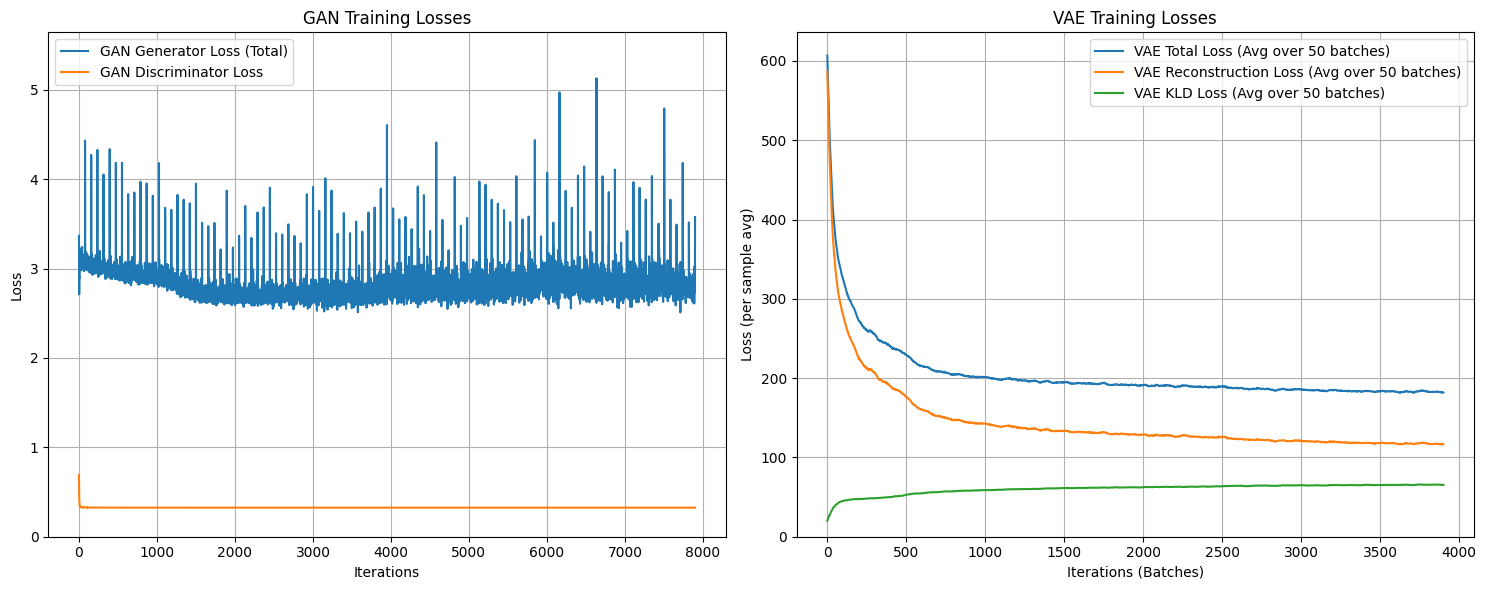

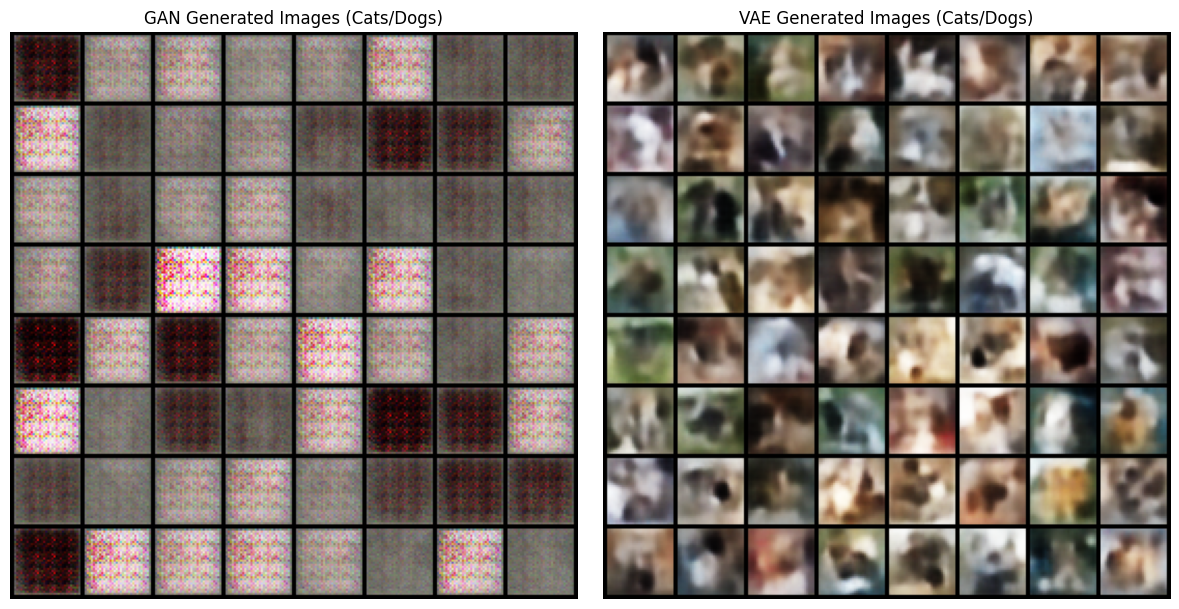

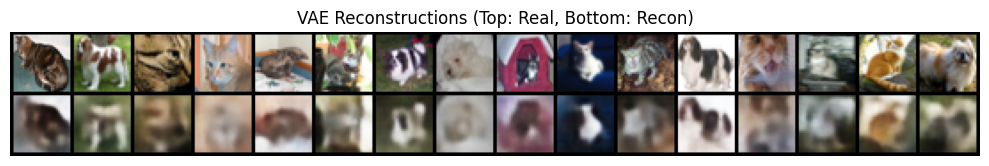

In [28]:
import argparse
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

# Ensure reproducibility
# torch.manual_seed(42)
# np.random.seed(42)

# --- Argument Parsing ---
# ... (keep existing arguments)
parser = argparse.ArgumentParser(description='CIFAR-10 Cat/Dog GAN & VAE Comparison')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs_gan', type=int, default=100, metavar='N', # Keep epochs for now
                    help='number of epochs to train GAN (default: 100)')
parser.add_argument('--epochs_vae', type=int, default=50, metavar='N',
                    help='number of epochs to train VAE (default: 50)')
# --- MODIFIED LEARNING RATES ---
parser.add_argument('--lr_g', type=float, default=0.0002, metavar='LR', # Keep G's LR for now, or try 0.0001
                    help='learning rate for GAN Generator (default: 0.0002)')
parser.add_argument('--lr_d', type=float, default=0.0001, metavar='LR', # REDUCE D's LR
                    help='learning rate for GAN Discriminator (default: 0.0001)')
# --- END MODIFIED LEARNING RATES ---
parser.add_argument('--lr_vae', type=float, default=0.001, metavar='LR',
                    help='learning rate for VAE (default: 0.001)')
parser.add_argument('--beta1', type=float, default=0.5,
                    help='Adam beta1 (default: 0.5)')
parser.add_argument('--z_dim', type=int, default=100, metavar='N',
                    help='dimension of latent vector z (default: 100)')
# --- INCREASED FM WEIGHT ---
parser.add_argument('--fm_lambda', type=float, default=10.0, # INCREASED from 1.0
                    help='Weight for Feature Matching loss (default: 10.0)')
# --- END INCREASED FM WEIGHT ---
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--output_dir', type=str, default='./results',
                    help='directory to save results')

args = parser.parse_args([]) # Or use parser.parse_args() in script
# ... rest of the setup code ...
# --- Device Setup ---
use_cuda = not args.no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Create output directory
os.makedirs(args.output_dir, exist_ok=True)
os.makedirs(os.path.join(args.output_dir, 'gan_images'), exist_ok=True)
os.makedirs(os.path.join(args.output_dir, 'vae_images'), exist_ok=True)
os.makedirs(os.path.join(args.output_dir, 'vae_reconstructions'), exist_ok=True)


# --- Data Preparation ---
print("Preparing Data...")
IMG_SIZE = 32
CHANNELS = 3
# Normalization: Images scaled to [-1, 1] for Tanh activation
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # To [-1, 1]
])

# Load CIFAR-10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Filter for cats (label 3) and dogs (label 5)
def filter_classes(dataset, classes):
    class_indices = {cls: i for i, cls in enumerate(dataset.classes)}
    target_labels = [class_indices[cls] for cls in classes]
    
    data = []
    targets = []
    for img, label in dataset:
        if label in target_labels:
            data.append(img)
            # Remap labels to 0, 1 for consistency if needed, though not strictly necessary here
            # new_label = target_labels.index(label) 
            targets.append(label) # Keep original label for potential checks
            
    return torch.stack(data), torch.tensor(targets)

cat_dog_classes = ['cat', 'dog']
train_data, train_targets = filter_classes(cifar10_train, cat_dog_classes)
test_data, test_targets = filter_classes(cifar10_test, cat_dog_classes)

# Create custom datasets
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

train_dataset = CustomDataset(train_data, train_targets)
test_dataset = CustomDataset(test_data, test_targets) # We might not use test set extensively here

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2, pin_memory=True)

print(f"Filtered dataset size: {len(train_dataset)} training images (Cats and Dogs)")


# --- GAN Implementation ---

# Weight Initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator (DCGAN Style)
class Generator(nn.Module):
    def __init__(self, z_dim, channels, ngf=64):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (channels) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

# Custom Discriminator (Siamese-like for Similarity)
class Discriminator(nn.Module):
    def __init__(self, channels, ndf=64):
        super(Discriminator, self).__init__()
        # Feature Extractor Backbone (shared weights)
        self.feature_extractor = nn.Sequential(
            # input is (channels) x 32 x 32
            nn.Conv2d(channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
             nn.Conv2d(ndf * 4, ndf * 8, 4, 1, 0, bias=False), # Output feature map
             #nn.BatchNorm2d(ndf * 8), # Optional BN here
             #nn.LeakyReLU(0.2, inplace=True),
             # state size. (ndf*8) x 1 x 1
        )
        
        self.final_dim = ndf * 8 # Dimension of the feature vector

        # Similarity Head
        # Takes the absolute difference of the two feature vectors
        self.similarity_head = nn.Sequential(
            nn.Linear(self.final_dim, 128), # Process the difference
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output similarity score between 0 (dissimilar) and 1 (similar)
        )

    def forward_features(self, img):
        features = self.feature_extractor(img)
        # Flatten features before similarity head
        # features_flat = features.view(features.size(0), -1) # Flatten if needed after Conv
        return features # Return intermediate features for Feature Matching

    def forward(self, img1, img2):
        feat1 = self.forward_features(img1)
        feat2 = self.forward_features(img2)
        
        # Flatten the features for the similarity head
        feat1_flat = feat1.view(feat1.size(0), -1)
        feat2_flat = feat2.view(feat2.size(0), -1)

        # Calculate absolute difference
        diff = torch.abs(feat1_flat - feat2_flat)
        
        # Get similarity score
        similarity = self.similarity_head(diff)
        
        # Return features from one branch (e.g., real) for feature matching loss
        # And the final similarity score
        return similarity.view(-1), feat1 # Returning feat1 (from img1, assumed real)

# Initialize models
netG = Generator(args.z_dim, CHANNELS).to(device)
netD = Discriminator(CHANNELS).to(device)
netG.apply(weights_init)
netD.apply(weights_init)

print("Generator Architecture:")
print(netG)
print("\nDiscriminator Architecture:")
print(netD)

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas=(args.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas=(args.beta1, 0.999))

# Loss function for similarity score (Binary Cross Entropy)
# D wants similarity(real, fake) -> 0 (dissimilar)
# G wants similarity(real, fake) -> 1 (similar)
criterion_similarity = nn.BCELoss()

# Feature Matching Loss (L1 distance between mean features)
criterion_fm = nn.L1Loss()

# Fixed noise for visualization
fixed_noise = torch.randn(64, args.z_dim, 1, 1, device=device)


# --- GAN Training Loop ---
print("\nStarting GAN Training...")# --- GAN Training Loop ---
print("\nStarting GAN Training...")
G_losses = []
D_losses = []
FM_losses = [] # Track feature matching loss component for G
img_list_gan = []
iters = 0
start_time_gan = time.time()

# --- LABEL SMOOTHING VALUES ---
real_label_val = 0.9 # Target for 'similar' (for G)
fake_label_val = 0.1 # Target for 'dissimilar' (for D)
# --- END LABEL SMOOTHING VALUES ---


for epoch in range(args.epochs_gan):
    epoch_start_time = time.time()
    for i, (real_images, _) in enumerate(train_loader):

        # --- Train Discriminator ---
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Generate fake image batch with G
        noise = torch.randn(b_size, args.z_dim, 1, 1, device=device)
        fake_images = netG(noise)

        # Labels for similarity loss (SMOOTHED)
        # D wants low similarity for real-fake pairs (target label close to 0)
        label_dissimilar = torch.full((b_size,), fake_label_val, dtype=torch.float, device=device) # Use fake_label_val

        # Calculate D's similarity prediction on real-fake pairs
        similarity_real_fake, _ = netD(real_images, fake_images.detach())

        # Calculate D loss
        errD = criterion_similarity(similarity_real_fake, label_dissimilar)

        # Backward pass and update D
        errD.backward()
        optimizerD.step()

        # --- Train Generator ---
        netG.zero_grad()

        # G wants high similarity for real-fake pairs (target label close to 1) (SMOOTHED)
        label_similar = torch.full((b_size,), real_label_val, dtype=torch.float, device=device) # Use real_label_val

        # Since we just updated D, perform another forward pass through D for G update
        similarity_real_fake_for_G, features_real = netD(real_images, fake_images)

        # Calculate G's similarity loss based on D's output
        errG_sim = criterion_similarity(similarity_real_fake_for_G, label_similar)

        # Feature Matching Loss (remains the same logic)
        with torch.no_grad():
             _, features_real_detached = netD(real_images, real_images)

        _, features_fake = netD(fake_images, fake_images)

        mean_features_real = torch.mean(features_real_detached, dim=0)
        mean_features_fake = torch.mean(features_fake, dim=0)
        errG_fm = criterion_fm(mean_features_fake, mean_features_real)

        # Total G loss (FM WEIGHT is applied here via args.fm_lambda)
        errG = errG_sim + args.fm_lambda * errG_fm

        # Backward pass and update G
        errG.backward()
        optimizerG.step()

        # --- Logging ---
        if i % args.log_interval == 0:
            print(f'[GAN Epoch {epoch}/{args.epochs_gan}] [Batch {i}/{len(train_loader)}] '
                  f'[D loss: {errD.item():.4f}] [G loss (Sim): {errG_sim.item():.4f}] '
                  f'[G loss (FM): {errG_fm.item():.4f}] [G loss (Total): {errG.item():.4f}]')

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        FM_losses.append(errG_fm.item())

        # --- Checkpoint: Save generated images ---
        if (iters % 500 == 0) or ((epoch == args.epochs_gan-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake_sample = netG(fixed_noise).detach().cpu()
            img_list_gan.append(make_grid(fake_sample, padding=2, normalize=True))
            save_image(img_list_gan[-1], f'{args.output_dir}/gan_images/gan_fake_samples_epoch_{epoch}_iter_{iters}.png')

    

        iters += 1

    print(f"Time for GAN epoch {epoch}: {time.time() - epoch_start_time:.2f} seconds")

# ... rest of the GAN training code ...

end_time_gan = time.time()
print(f"Total GAN Training Time: {(end_time_gan - start_time_gan)/60:.2f} minutes")

# Save final models
torch.save(netG.state_dict(), f'{args.output_dir}/gan_generator.pth')
torch.save(netD.state_dict(), f'{args.output_dir}/gan_discriminator.pth')

print("Finished GAN Training.")


# --- VAE Implementation ---

class VAE(nn.Module):
    def __init__(self, channels, latent_dim=128, h_dim=1024):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        nc = channels
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(nc, 32, kernel_size=4, stride=2, padding=1), # -> 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1), # -> 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x4x4
            nn.ReLU(),
            nn.Flatten() # -> 128*4*4 = 2048
        )
        
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        
        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 128 * 4 * 4)
        
        self.decoder = nn.Sequential(
             # Reshape -> 128 x 4 x 4
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1), # -> 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # -> 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, nc, kernel_size=4, stride=2, padding=1), # -> 3x32x32
            nn.Tanh() # Output needs to be in [-1, 1] to match input normalization and use MSE
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(h.size(0), 128, 4, 4) # Reshape to match ConvTranspose input
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# VAE Loss Function
def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    # Use Mean Squared Error for reconstruction loss with Tanh output
    MSE = F.mse_loss(recon_x, x, reduction='sum') 
    
    # KL divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # where sigma^2 = exp(logvar)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return MSE + beta * KLD, MSE, KLD


# Initialize VAE Model and Optimizer
vae_model = VAE(channels=CHANNELS, latent_dim=args.z_dim).to(device) # Use same latent dim for comparison
optimizer_vae = optim.Adam(vae_model.parameters(), lr=args.lr_vae)

print("\nVAE Architecture:")
print(vae_model)


# --- VAE Training Loop ---
print("\nStarting VAE Training...")
vae_losses = []
recon_losses = []
kld_losses = []
img_list_vae = []
recon_list_vae = []
start_time_vae = time.time()

vae_model.train() # Set model to training mode
for epoch in range(args.epochs_vae):
    epoch_start_time = time.time()
    total_loss_epoch = 0
    total_recon_loss_epoch = 0
    total_kld_loss_epoch = 0

    for i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer_vae.zero_grad()
        
        recon_batch, mu, logvar = vae_model(data)
        loss, recon_loss, kld_loss = vae_loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        optimizer_vae.step()
        
        total_loss_epoch += loss.item()
        total_recon_loss_epoch += recon_loss.item()
        total_kld_loss_epoch += kld_loss.item()

        if i % args.log_interval == 0:
             print(f'[VAE Epoch {epoch}/{args.epochs_vae}] [Batch {i}/{len(train_loader)}] '
                  f'[Total loss: {loss.item() / len(data):.4f}] '
                  f'[Recon loss: {recon_loss.item() / len(data):.4f}] '
                  f'[KLD loss: {kld_loss.item() / len(data):.4f}]')
        
        # Log per-batch average losses
        vae_losses.append(loss.item() / len(data))
        recon_losses.append(recon_loss.item() / len(data))
        kld_losses.append(kld_loss.item() / len(data))

    avg_loss = total_loss_epoch / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss_epoch / len(train_loader.dataset)
    avg_kld_loss = total_kld_loss_epoch / len(train_loader.dataset)
    
    print(f'====> VAE Epoch: {epoch} Average loss: {avg_loss:.4f} '
          f'(Recon: {avg_recon_loss:.4f}, KLD: {avg_kld_loss:.4f}) '
          f'Time: {time.time() - epoch_start_time:.2f}s')

    # --- Checkpoint: Save generated samples and reconstructions ---
    if epoch % 5 == 0 or epoch == args.epochs_vae - 1:
         vae_model.eval() # Set model to evaluation mode
         with torch.no_grad():
            # Generate samples from prior
            sample_z = torch.randn(64, args.z_dim).to(device)
            generated_sample = vae_model.decode(sample_z).cpu()
            img_list_vae.append(make_grid(generated_sample, padding=2, normalize=True))
            save_image(img_list_vae[-1], f'{args.output_dir}/vae_images/vae_generated_samples_epoch_{epoch}.png')

            # Reconstruct some training images
            real_batch_sample, _ = next(iter(train_loader))
            real_batch_sample = real_batch_sample[:16].to(device) # Take 16 samples
            recon_batch_sample, _, _ = vae_model(real_batch_sample)
            
            comparison = torch.cat([real_batch_sample.cpu(), 
                                    recon_batch_sample.cpu()])
            comparison_grid = make_grid(comparison, nrow=16, padding=2, normalize=True)
            recon_list_vae.append(comparison_grid)
            save_image(comparison_grid, f'{args.output_dir}/vae_reconstructions/vae_reconstruction_epoch_{epoch}.png')
         vae_model.train() # Set back to training mode

end_time_vae = time.time()
print(f"Total VAE Training Time: {(end_time_vae - start_time_vae)/60:.2f} minutes")

# Save final VAE model
torch.save(vae_model.state_dict(), f'{args.output_dir}/vae_model.pth')

print("Finished VAE Training.")


# --- Comparison and Visualization ---
print("\nGenerating Comparison Plots...")

# 1. Loss Curves
plt.figure(figsize=(15, 6))

# GAN Losses
plt.subplot(1, 2, 1)
plt.plot(G_losses, label='GAN Generator Loss (Total)')
plt.plot(D_losses, label='GAN Discriminator Loss')
# plt.plot(FM_losses, label='GAN Generator FM Loss') # Optional: Plot FM loss separately
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.ylim(0, max(max(G_losses), max(D_losses)) * 1.1 if G_losses and D_losses else 10) # Adjust ylim if needed
plt.title("GAN Training Losses")
plt.legend()
plt.grid(True)

# VAE Losses
plt.subplot(1, 2, 2)
# Plotting moving average for VAE losses might be smoother if noisy
window_size = 50 
def moving_average(data, window_size):
    if not data: return []
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Note: Batch losses logged. Plotting raw or moving average
plt.plot(moving_average(vae_losses, window_size), label=f'VAE Total Loss (Avg over {window_size} batches)')
plt.plot(moving_average(recon_losses, window_size), label=f'VAE Reconstruction Loss (Avg over {window_size} batches)')
plt.plot(moving_average(kld_losses, window_size), label=f'VAE KLD Loss (Avg over {window_size} batches)')
# plt.plot(vae_losses, label='VAE Total Loss (per batch avg)') # Raw plot
plt.xlabel("Iterations (Batches)")
plt.ylabel("Loss (per sample avg)")
plt.title("VAE Training Losses")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)

plt.tight_layout()
plt.savefig(f'{args.output_dir}/loss_curves_comparison.png')
print(f"Loss curves saved to {args.output_dir}/loss_curves_comparison.png")
# plt.show() # Keep commented out for Kaggle background runs


# 2. Visual Quality - Generated Images
plt.figure(figsize=(12, 6))

# GAN Generated Images (Last saved sample)
if img_list_gan:
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("GAN Generated Images (Cats/Dogs)")
    plt.imshow(np.transpose(img_list_gan[-1], (1, 2, 0)))
else:
    print("No GAN images were saved.")

# VAE Generated Images (Last saved sample)
if img_list_vae:
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("VAE Generated Images (Cats/Dogs)")
    plt.imshow(np.transpose(img_list_vae[-1], (1, 2, 0)))
else:
    print("No VAE images were saved.")

plt.tight_layout()
plt.savefig(f'{args.output_dir}/generated_images_comparison.png')
print(f"Generated images comparison saved to {args.output_dir}/generated_images_comparison.png")
# plt.show()


# 3. VAE Reconstructions (Last saved sample)
if recon_list_vae:
    plt.figure(figsize=(10, 4)) # Adjust as needed
    plt.axis("off")
    plt.title("VAE Reconstructions (Top: Real, Bottom: Recon)")
    plt.imshow(np.transpose(recon_list_vae[-1],(1,2,0)))
    plt.tight_layout()
    plt.savefig(f'{args.output_dir}/vae_reconstructions_final.png')
    print(f"VAE reconstructions saved to {args.output_dir}/vae_reconstructions_final.png")
    # plt.show()
else:
    print("No VAE reconstructions were saved.")

print("\n--- Final Comparison Summary ---")

# Quantitative Metrics
print("\nQuantitative Metrics:")
if D_losses and G_losses:
     final_d_loss = D_losses[-1]
     final_g_loss = G_losses[-1]
     avg_sim_score_g = 1.0 - final_g_loss # Rough estimate, G tries to push similarity score towards 1 (BCE loss target 1)
     print(f"  GAN Final D Loss: {final_d_loss:.4f}")
     print(f"  GAN Final G Loss (Total): {final_g_loss:.4f}")
     # The similarity score itself isn't directly minimized/maximized, the BCE loss is.
     # We can evaluate the D's output on fake images at the end:
     netG.eval()
     netD.eval()
     with torch.no_grad():
         eval_noise = torch.randn(args.batch_size, args.z_dim, 1, 1, device=device)
         eval_fake = netG(eval_noise)
         # Get a batch of real images
         eval_real, _ = next(iter(train_loader))
         eval_real = eval_real.to(device)
         # Use only as many real images as fake images generated
         if eval_real.size(0) > eval_fake.size(0):
             eval_real = eval_real[:eval_fake.size(0)]
         elif eval_fake.size(0) > eval_real.size(0):
             eval_fake = eval_fake[:eval_real.size(0)]

         final_similarity, _ = netD(eval_real, eval_fake)
         avg_final_similarity = final_similarity.mean().item()
         print(f"  GAN Final Avg Similarity (D(real, G(z))): {avg_final_similarity:.4f} (G wants 1, D wants 0)")

else:
     print("  GAN training did not produce loss values.")

if vae_losses and recon_losses and kld_losses:
    # Use the epoch averages from the last epoch
    # Note: avg_loss, avg_recon_loss, avg_kld_loss calculated above are per-sample averages over the last epoch
    print(f"  VAE Final Avg Total Loss (per sample): {avg_loss:.4f}")
    print(f"  VAE Final Avg Reconstruction Loss (per sample): {avg_recon_loss:.4f}")
    print(f"  VAE Final Avg KLD Loss (per sample): {avg_kld_loss:.4f}")
else:
     print("  VAE training did not produce loss values.")

# Qualitative Observations (Manual Interpretation)
print("\nQualitative Observations (Interpret from saved images):")
print("  Visual Quality: Compare 'generated_images_comparison.png'. GANs might produce sharper but potentially less diverse images (check for mode collapse). VAEs might produce blurrier but more varied outputs.")
print("  Convergence: Examine 'loss_curves_comparison.png'. GAN losses are often oscillatory and don't necessarily converge to zero. Look for stability. VAE losses should ideally decrease steadily.")
print("  VAE Reconstructions: Check 'vae_reconstructions_final.png' to see how well the VAE captures the data distribution features.")
print("  Diversity (GAN): Visually inspect multiple GAN outputs (if saved periodically) or the final grid for signs of mode collapse (many similar images). Feature Matching aims to mitigate this.")

print("\nStrengths & Weaknesses:")
print("  GAN:")
print("    + Strengths: Often produces sharper, more realistic-looking samples (when trained well).")
print("    - Weaknesses: Training instability, mode collapse, custom discriminator similarity score is hard to interpret directly.")
print("  VAE:")
print("    + Strengths: Stable training, provides useful reconstructions, latent space often smoother/more interpretable.")
print("    - Weaknesses: Generated samples can be blurry compared to GANs, reconstruction loss might dominate KLD leading to less 'imaginative' generation.")

print("\nPotential Improvements:")
print("  - Hyperparameter tuning (learning rates, latent dims, loss weights).")
print("  - Different GAN diversity techniques (e.g., Mini-batch Discrimination).")
print("  - More sophisticated GAN architectures (e.g., StyleGAN variants - complex).")
print("  - Different VAE architectures (e.g., adding more layers, residual connections).")
print("  - Using alternative VAE loss formulations (e.g., Beta-VAE with beta > 1 for more disentanglement).")
print("  - Implementing quantitative metrics like FID or IS for a more standardized comparison (requires installing specific libraries and potentially using a pretrained Inception network).")

print(f"\nAll results saved in: {args.output_dir}")